# Logistic Regression Training

This notebook shows how to train a logistic regression model on encrypted data using stochastic gradient descent (SGD). During this process,
the training set remains encrypted at all times and the gradients and loss are encrypted, thus unaccessible by the server performing the training. 

The result of the encrypted training is a set of encrypted model weights that can only be decrypted by the training set secret-key owner. In Concrete ML the `fit` function encrypts the training data, trains the model producing encrypted weights and then decrypts the weights. The model can then be used in on clear data, or on new encrypted data.

Training on encrypted data is especially useful when multiple parties collaborate confidentially, meaning they provide encrypted shares of a training set. 

In this notebook, a Scikit-Learn model is first trained as the baseline. Next, a Concrete ML model is trained on encrypted data using Fully Homomorphic Encryption.

In [1]:
%matplotlib inline
# Import dataset libraries and util functions
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from sklearn import datasets
from sklearn.linear_model import SGDClassifier as SklearnSGDClassifier
from sklearn.preprocessing import MinMaxScaler

from concrete.ml.sklearn import SGDClassifier


def plot_decision_boundary(clf, X, y, n_iterations, title="Decision Boundary", accuracy=None):
    # Create a mesh to plot the decision boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # Predictions to get the decision boundary
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Define red and blue color map
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cm_bright)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap=cm_bright)
    plt.title(
        f"{title} (Iterations: {n_iterations}, Accuracy: {accuracy})\n "
        f"Learned weights: {clf.coef_[0][0]:.3f}, {clf.coef_[0][1]:.3f}, "
        f"{clf.intercept_.reshape((-1,))[0]:.3f} "
    )
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    # Create a custom legend
    legend_elements = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Class 0",
            markerfacecolor="#FF0000",
            markersize=10,
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Class 1",
            markerfacecolor="#0000FF",
            markersize=10,
        ),
    ]
    plt.legend(handles=legend_elements, loc="upper right")

    plt.show()


# Load the Iris dataset
Xfull, y = datasets.load_iris(return_X_y=True)
Xfull = MinMaxScaler(feature_range=[-1, 1]).fit_transform(Xfull)

# Select petal length and petal width for visualization
X = Xfull[:, 2:4]  # Petal length and petal width

# Filter the dataset for binary classification (Versicolor and Virginica)
# These correspond to target labels 1 and 2 in the Iris dataset
binary_filter = (y == 1) | (y == 2)
X_binary = X[binary_filter]
Xfull_binary = Xfull[binary_filter]
y_binary = y[binary_filter] - 1

## Baseline Scikit-learn Training on Clear Data 

Training of the typical Scikit-Learn baseline. A Logistic Regression model is trained using SGD. 

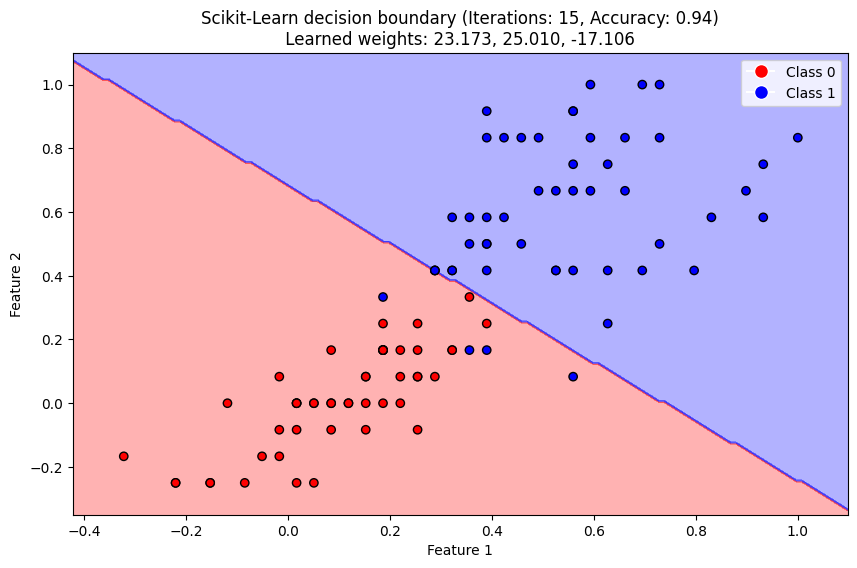

In [2]:
# Train an SGDClassifier on the binary dataset
N_ITERATIONS = 15
RANDOM_STATE = 42

sgd_clf_binary = SklearnSGDClassifier(random_state=RANDOM_STATE, max_iter=N_ITERATIONS)
sgd_clf_binary.fit(X_binary, y_binary)
y_pred = sgd_clf_binary.predict(X_binary)
accuracy = (y_pred == y_binary).mean()
plot_decision_boundary(
    sgd_clf_binary,
    X_binary,
    y_binary,
    n_iterations=N_ITERATIONS,
    accuracy=accuracy,
    title="Scikit-Learn decision boundary",
)

## Training on Encrypted Data with Concrete ML

Training over encrypted data in FHE using SGD. Compared to the equivalent scikit-learn class, two new parameters need to be set: `fit_encrypted=True` and `parameters_range`. 

Compiling training circuit ...


Compilation took 2.1189 seconds.
Key Generation...
Key generation took 2.6738 seconds.
Training on encrypted data...


Iteration 0 took 3.7561 seconds.


Iteration 1 took 3.1317 seconds.


Iteration 2 took 3.2766 seconds.
Iteration 3 took 2.0686 seconds.


Iteration 4 took 2.0651 seconds.


Iteration 5 took 3.5328 seconds.


Iteration 6 took 3.8961 seconds.
Iteration 7 took 2.2215 seconds.


Iteration 8 took 3.6884 seconds.


Iteration 9 took 2.1487 seconds.


Iteration 10 took 2.8907 seconds.


Iteration 11 took 2.5547 seconds.


Iteration 12 took 2.1548 seconds.


Iteration 13 took 2.4237 seconds.


Iteration 14 took 2.2274 seconds.


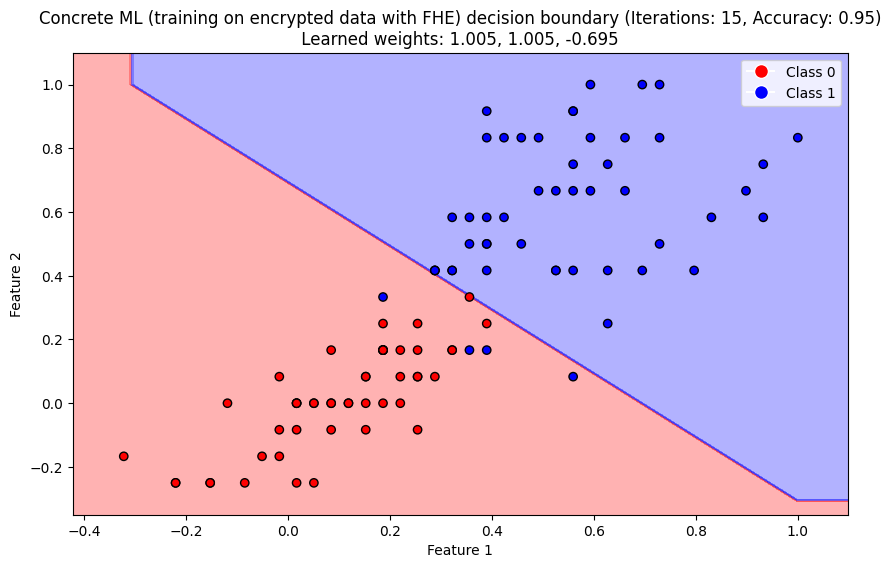

In [3]:
parameters_range = (-1.0, 1.0)

sgd_clf_binary_fhe = SGDClassifier(
    random_state=RANDOM_STATE,
    max_iter=N_ITERATIONS,
    fit_encrypted=True,
    parameters_range=parameters_range,
    verbose=True,
)

# Fit on encrypted data
sgd_clf_binary_fhe.fit(X_binary, y_binary, fhe="execute")

# The weights are decrypted at the end of the `fit` call. Use the clear weights here
# to evaluate accuracy on clear data
y_pred = sgd_clf_binary_fhe.predict(X_binary)

# Evaluate the decrypted weights on encrypted data
sgd_clf_binary_fhe.compile(X_binary)
y_pred_fhe = sgd_clf_binary_fhe.predict(X_binary, fhe="execute")

# Check that the same result is obtained when applying
# the decrypted model on clear data and on encrypted data
# Linear classifiers are 100% correct on encrypted data compared to execution on clear data
assert np.all(y_pred == y_pred_fhe)

accuracy = (y_pred == y_binary).mean()

plot_decision_boundary(
    sgd_clf_binary_fhe,
    X_binary,
    y_binary,
    n_iterations=N_ITERATIONS,
    accuracy=accuracy,
    title="Concrete ML (training on encrypted data with FHE) decision boundary",
)

## Validate Encrypted Training using Simulation

FHE simulation is a way to test an FHE program on cleartext data, providing a fast way
to determine the behavior of an algorithm over encrypted data. Inputs and results of FHE simulation are not encrypted
but the the results are quickly obtained so they can be analyzed to show if any errors are introduced by the execution
of the algorithm with FHE.

### Get a different dataset that has more features

In [4]:
from sklearn.model_selection import train_test_split

X2, y2 = datasets.load_breast_cancer(return_X_y=True)
x2_train, x2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, stratify=y2)

scaler = MinMaxScaler(feature_range=[-1, 1])
x2_train = scaler.fit_transform(x2_train)
x2_test = scaler.transform(x2_test)

rng = np.random.default_rng(RANDOM_STATE)
perm = rng.permutation(x2_train.shape[0])
x2_train = x2_train[perm, ::]
y2_train = y2_train[perm]

### Configure the FHE training algorithm and simulate

In [5]:
parameters_range = (-1.0, 1.0)

sklearn_sgd = SklearnSGDClassifier()
sklearn_sgd.fit(x2_train, y2_train)
accuracy_sk = np.mean(sklearn_sgd.predict(x2_test) == y2_test)
print(f"Sklearn clear accuracy: {accuracy_sk*100:.2f}%")

sgd_clf_binary_simulate = SGDClassifier(
    random_state=RANDOM_STATE,
    max_iter=N_ITERATIONS,
    fit_encrypted=True,
    parameters_range=parameters_range,
)

# Train with simulation on the full dataset
sgd_clf_binary_simulate.fit(x2_train, y2_train, fhe="simulate")

# Measure accuracy on the test set using simulation
sgd_clf_binary_simulate.compile(x2_train)
y_pred_fhe = sgd_clf_binary_simulate.predict(x2_test, fhe="simulate")
accuracy = (y_pred_fhe == y2_test).mean()
print(f"Full encrypted fit (simulated) accuracy {accuracy*100:.2f}%")

Sklearn clear accuracy: 96.49%


Full encrypted fit (simulated) accuracy 94.15%


### Evaluate accuracy evolution during training

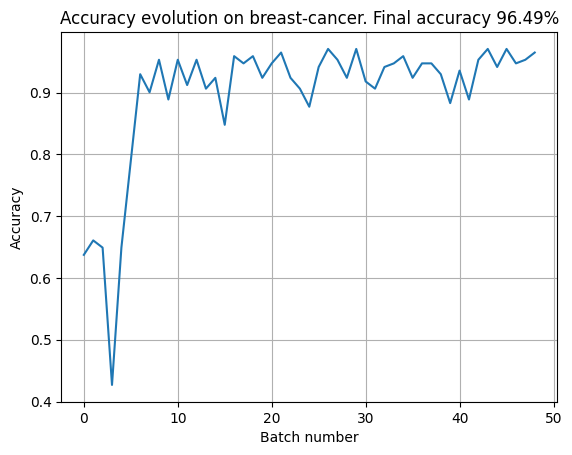

In [6]:
# To measure accuracy after every batch initialize the SGDClassifier with warm_start=True
# which keeps the weights obtained with previous batches

sgd_clf_binary_simulate = SGDClassifier(
    random_state=RANDOM_STATE,
    max_iter=N_ITERATIONS,
    fit_encrypted=True,
    parameters_range=parameters_range,
    warm_start=True,
)

batch_size = sgd_clf_binary_simulate.batch_size

# Go through the training batches
acc_history = []
for idx in range(x2_train.shape[0] // batch_size):
    batch_range = range(idx * batch_size, (idx + 1) * batch_size)
    x_batch = x2_train[batch_range, ::]
    y_batch = y2_train[batch_range]

    # Fit on a single batch with partial_fit
    sgd_clf_binary_simulate.partial_fit(x_batch, y_batch, fhe="simulate")

    # Measure accuracy of the model with FHE simulation
    sgd_clf_binary_simulate.compile(x2_train)
    y_pred_fhe = sgd_clf_binary_simulate.predict(x2_test, fhe="simulate")
    accuracy = (y_pred_fhe == y2_test).mean()
    acc_history.append(accuracy)

# Plot the evolution of accuracy throughout the training process
fig = plt.figure()
plt.plot(acc_history)
plt.title(f"Accuracy evolution on breast-cancer. Final accuracy {acc_history[-1]*100:.2f}%")
plt.xlabel("Batch number")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()